In [1]:
# Imports
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical

import glob
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import numpy
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, confusion_matrix

In [2]:
# Constantes
IMAGE_SIZE = 200
CLASSES = ['TOEI', 'GB', 'WIT']

In [3]:
!git clone https://github.com/Cooleure/BD_Animes.git
files_path = "./BD_Animes/"

Cloning into 'BD_Animes'...
remote: Enumerating objects: 5710, done.
remote: Counting objects: 100% (1768/1768), done.
remote: Compressing objects: 100% (1764/1764), done.
remote: Total 5710 (delta 6), reused 1758 (delta 3), pack-reused 3942
Receiving objects: 100% (5710/5710), 180.86 MiB | 10.72 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Updating files: 100% (5675/5675), done.


In [4]:
# Load data
def load_data(folder_path, classes, image_size=64):

  # Place aléatoirement les images dans les sous-ensembles train, validation et test
  # En récupérant les images dans chaque dossier film

  # Initialisation des sous-ensembles
  train = {'x': [], 'y': []}
  validation = {'x': [], 'y': []}
  test = {'x': [], 'y': []}

  # Liste les dossiers de films présents dans le dossier path
  files = glob.glob(folder_path + "/**/*.jpg", recursive = True)
  print(files)
  x_and_y_tuple = []
  # Load data pour chaque film
  for file in files:
    #x_and_y_tuple des images
    x_and_y_tuple.append(load_data_movie_file(file, classes, image_size))

  # Nombre d'images
  n = len(x_and_y_tuple)

  # Indices aléatoires
  indices = np.random.permutation(n)

  # Séparation des données
  train_indices = indices[:int(0.6*n)]
  validation_indices = indices[int(0.6*n):int(0.9*n)]
  test_indices = indices[int(0.9*n):]

  # Ajout des données
  train['x'] = [x_and_y_tuple[i][0] for i in train_indices ]
  train['y'] = [x_and_y_tuple[i][1] for i in train_indices ]
  validation['x'] = [x_and_y_tuple[i][0] for i in validation_indices ]
  validation['y'] = [x_and_y_tuple[i][1] for i in validation_indices ]
  test['x'] = [x_and_y_tuple[i][0] for i in test_indices ]
  test['y'] = [x_and_y_tuple[i][1] for i in test_indices ]

  return train, validation, test

def load_data_movie_file(file, classes, image_size=64):

  # Lecture de l'image + mise à l'échelle
  img = Image.open(file)
  img = img.resize((image_size, image_size), Image.LANCZOS)

  # Image + Label
  x = np.asarray(img)
  y = load_label(file, classes)

  return x, y

def load_label(path, classes):
  img_path_split = path.split('/')
  img_name_split = img_path_split[-1].split('_')
  return classes.index(img_name_split[0])


In [5]:
def plot_training_analysis(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def confusionMatrix(actual, predictions):
  predicted = [np.argmax(i) for i in predictions]
  conf_matrix = confusion_matrix(actual, predicted)

  cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = CLASSES)

  cm_display.plot()
  plt.show()

In [6]:
def exportModel(model, modelName):
  from google.colab import drive
  drive.mount('/content/drive')
  model.save('/content/drive/MyDrive/ApprentissageProfond/' + modelName)

In [7]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet152V2

def transferLearningModel(model="VGG16", image_size=IMAGE_SIZE, weights='imagenet', epochs=10, fine_tuning=False):
  ### Conv
  print("TRANSFER LEARNING")
  print("------------------------------")
  print("Conv")
  if (model == "VGG16"):
    conv = VGG16(weights=weights, include_top=False, input_shape=(image_size, image_size, 3))
  elif (model == "VGG19"):
    conv = VGG19(weights=weights, include_top=False, input_shape=(image_size, image_size, 3))
  elif (model == "Xception"):
    conv = Xception(weights=weights, include_top=False, input_shape=(image_size, image_size, 3))
  elif (model == "ResNet152V2"):
    conv = ResNet152V2(weights=weights, include_top=False, input_shape=(image_size, image_size, 3))

  conv.trainable = fine_tuning
  conv.summary()
  output_shape = np.prod(conv.output_shape[1:])

  # Features
  train_features = conv.predict(train['x'])
  train_features = np.reshape(train_features, (train_features.shape[0], output_shape))

  val_features = conv.predict(val['x'])
  val_features = np.reshape(val_features, (val_features.shape[0], output_shape))

  test_features = conv.predict(test['x'])
  test_features = np.reshape(test_features, (test_features.shape[0], output_shape))

  ### Model
  print("------------------------------")
  print("Model")
  model = Sequential()

  model.add(Dense(256, activation='relu', input_dim=output_shape))
  model.add(Dense(3, activation='softmax'))

  model.summary()

  if fine_tuning:
    rate = 3e-5
  else:
    rate = 3e-4

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(learning_rate=rate),
                metrics=['accuracy'])

  history = model.fit(train_features, train['y'],
                      epochs=epochs,
                      batch_size=100,
                      validation_data=(val_features, val['y']))

  ### Data visualization
  # Training
  plot_training_analysis(history)

  # Confusion matrix
  confusionMatrix(test['y'], model.predict(test_features)
)

  return model


In [8]:
# Data subsets

# Train, validation, test
train, val, test = load_data(files_path, CLASSES, image_size=IMAGE_SIZE)

# Normalisation des entrées via une division par 255 des valeurs de pixel.
train['x'] = np.array(train['x'])
val['x'] = np.array(val['x'])
test['x'] = np.array(test['x'])

train['y'] = np.array(train['y'])
val['y'] = np.array(val['y'])
test['y'] = np.array(test['y'])

['./BD_Animes/TOEI/DB/Output_TOEI_DB_09/TOEI_DB_09_29661.jpg', './BD_Animes/TOEI/DB/Output_TOEI_DB_09/TOEI_DB_09_25771.jpg', './BD_Animes/TOEI/DB/Output_TOEI_DB_09/TOEI_DB_09_16424.jpg', './BD_Animes/TOEI/DB/Output_TOEI_DB_09/TOEI_DB_09_26932.jpg', './BD_Animes/TOEI/DB/Output_TOEI_DB_09/TOEI_DB_09_28441.jpg', './BD_Animes/TOEI/DB/Output_TOEI_DB_09/TOEI_DB_09_7923.jpg', './BD_Animes/TOEI/DB/Output_TOEI_DB_09/TOEI_DB_09_14595.jpg', './BD_Animes/TOEI/DB/Output_TOEI_DB_09/TOEI_DB_09_14664.jpg', './BD_Animes/TOEI/DB/Output_TOEI_DB_09/TOEI_DB_09_15021.jpg', './BD_Animes/TOEI/DB/Output_TOEI_DB_09/TOEI_DB_09_28894.jpg', './BD_Animes/TOEI/DB/Output_TOEI_DB_09/TOEI_DB_09_34906.jpg', './BD_Animes/TOEI/DB/Output_TOEI_DB_09/TOEI_DB_09_21473.jpg', './BD_Animes/TOEI/DB/Output_TOEI_DB_09/TOEI_DB_09_11737.jpg', './BD_Animes/TOEI/DB/Output_TOEI_DB_09/TOEI_DB_09_12380.jpg', './BD_Animes/TOEI/DB/Output_TOEI_DB_09/TOEI_DB_09_20133.jpg', './BD_Animes/TOEI/DB/Output_TOEI_DB_09/TOEI_DB_09_22029.jpg', './BD_An

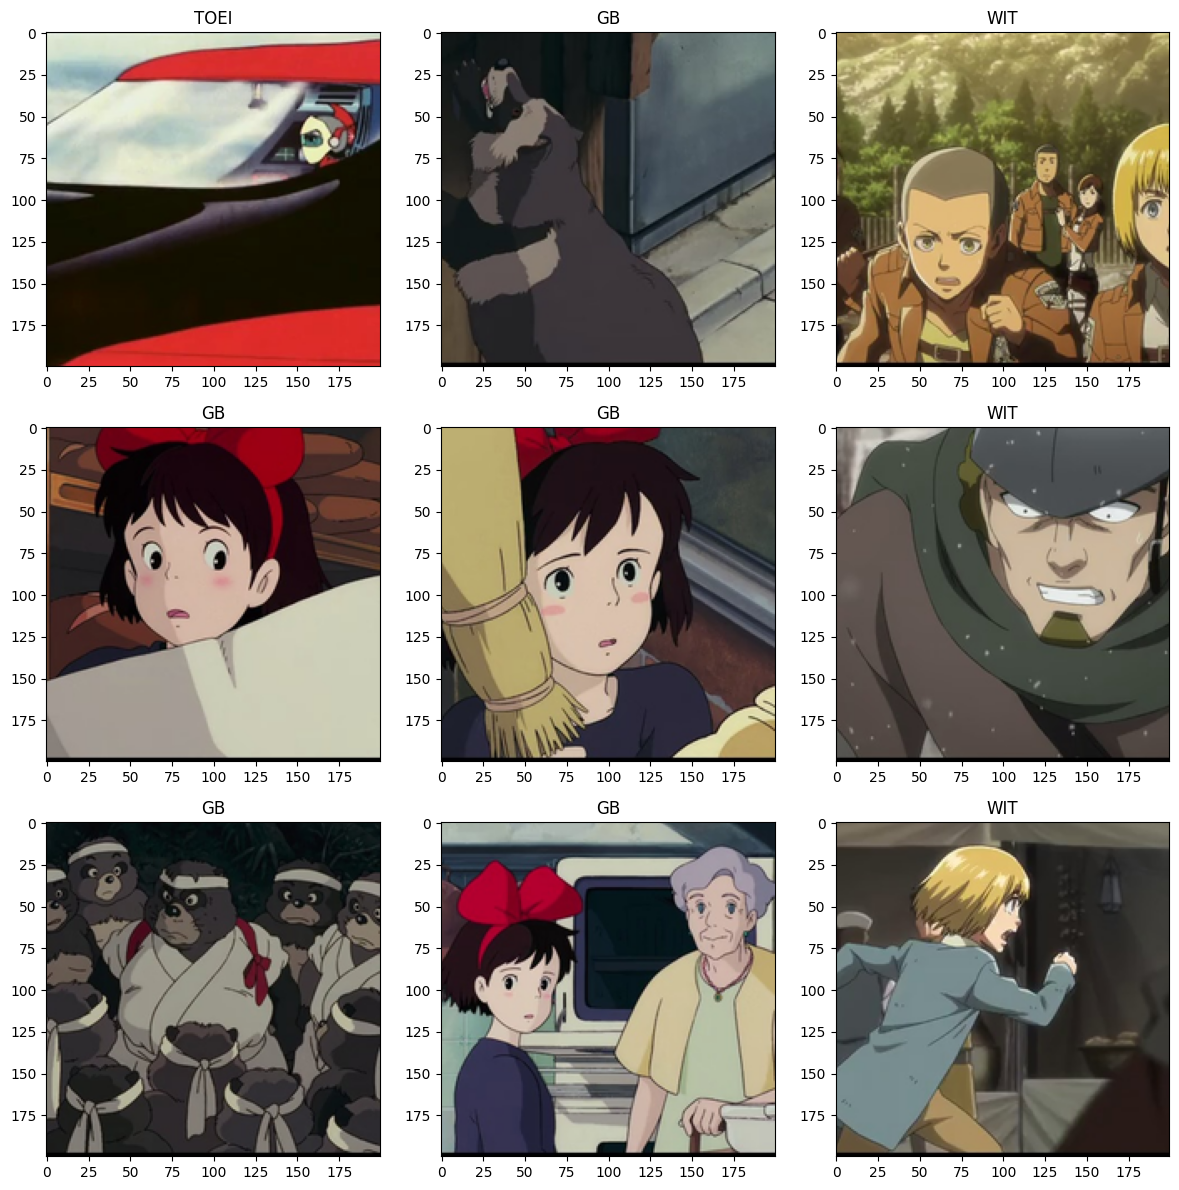

In [9]:
# Randomisation des indices
indices = np.arange(len(train['x']))
np.random.shuffle(indices)

# Affichage de 9 images aléatoires de la base d'apprentissage
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    random_index = indices[i]  # Utiliser les indices aléatoires
    plt.title(CLASSES[int(train['y'][random_index])])
    plt.imshow(train['x'][random_index])
plt.tight_layout()
plt.show()

{0: 1030, 1: 1172, 2: 1201}


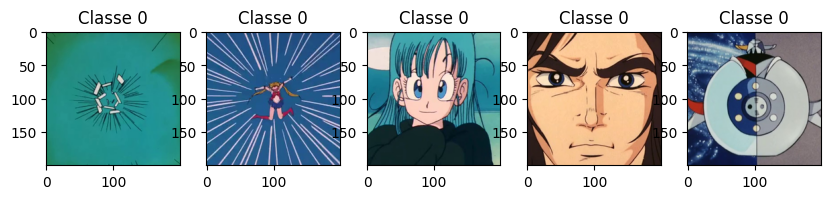

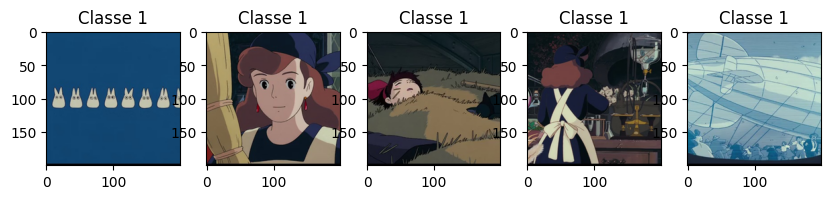

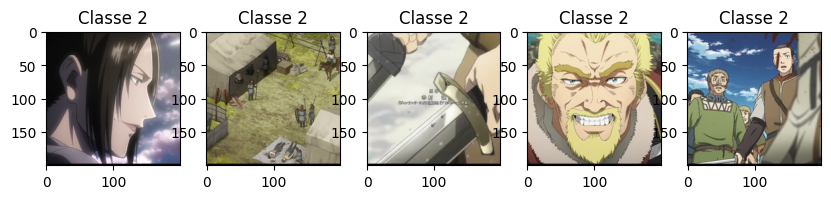

In [12]:
# Vérification de l'équilibre des classes

# Compter le nombre d'exemples pour chaque classe
unique, counts = np.unique(to_categorical(train['y']).argmax(axis=1), return_counts=True)
print(dict(zip(unique, counts)))

for i in range(3):  # Pour chaque classe
    indices = np.where(to_categorical(train['y']).argmax(axis=1) == i)[0]
    plt.figure(figsize=(10, 2))
    for j in range(5):  # Afficher 5 images par classe
        plt.subplot(1, 5, j+1)
        plt.imshow(train['x'][indices[j]])
        plt.title(f"Classe {i}")
    plt.show()

[2]


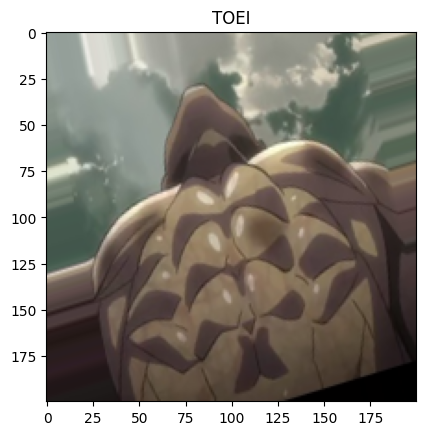

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation des données - génération d'images
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(
    rescale=1/255,
)

example_x, example_y = train_datagen.flow(train['x'], train['y'], batch_size=1).next()
for i in range(0,1):
    plt.imshow(example_x[i])
    plt.title(CLASSES[int(np.argmax(example_y[i]))])
    plt.show()

In [14]:
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 1
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3
model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 4
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 5
model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense
model.add(Dense(512, activation='relu'))   # Couche dense, à 512 neurones
model.add(Dense(3, activation='softmax'))   # Couche de sortie

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])



train_generator = train_datagen.flow(train['x'], to_categorical(train['y']), batch_size=10)
val_generator = val_datagen.flow(val['x'], to_categorical(val['y']), batch_size=10)
test_generator = val_datagen.flow(test['x'], to_categorical(test['y']), batch_size=10)

history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    batch_size=100)

# history = model.fit(train['x'], train['y'],
#                     validation_data=(val['x'], val['y']),
#                     epochs=10,
#                     batch_size=100)


plot_training_analysis(history)

predictions = model.predict(test_generator)
confusionMatrix(test['y'], predictions)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 64)        0

KeyboardInterrupt: 

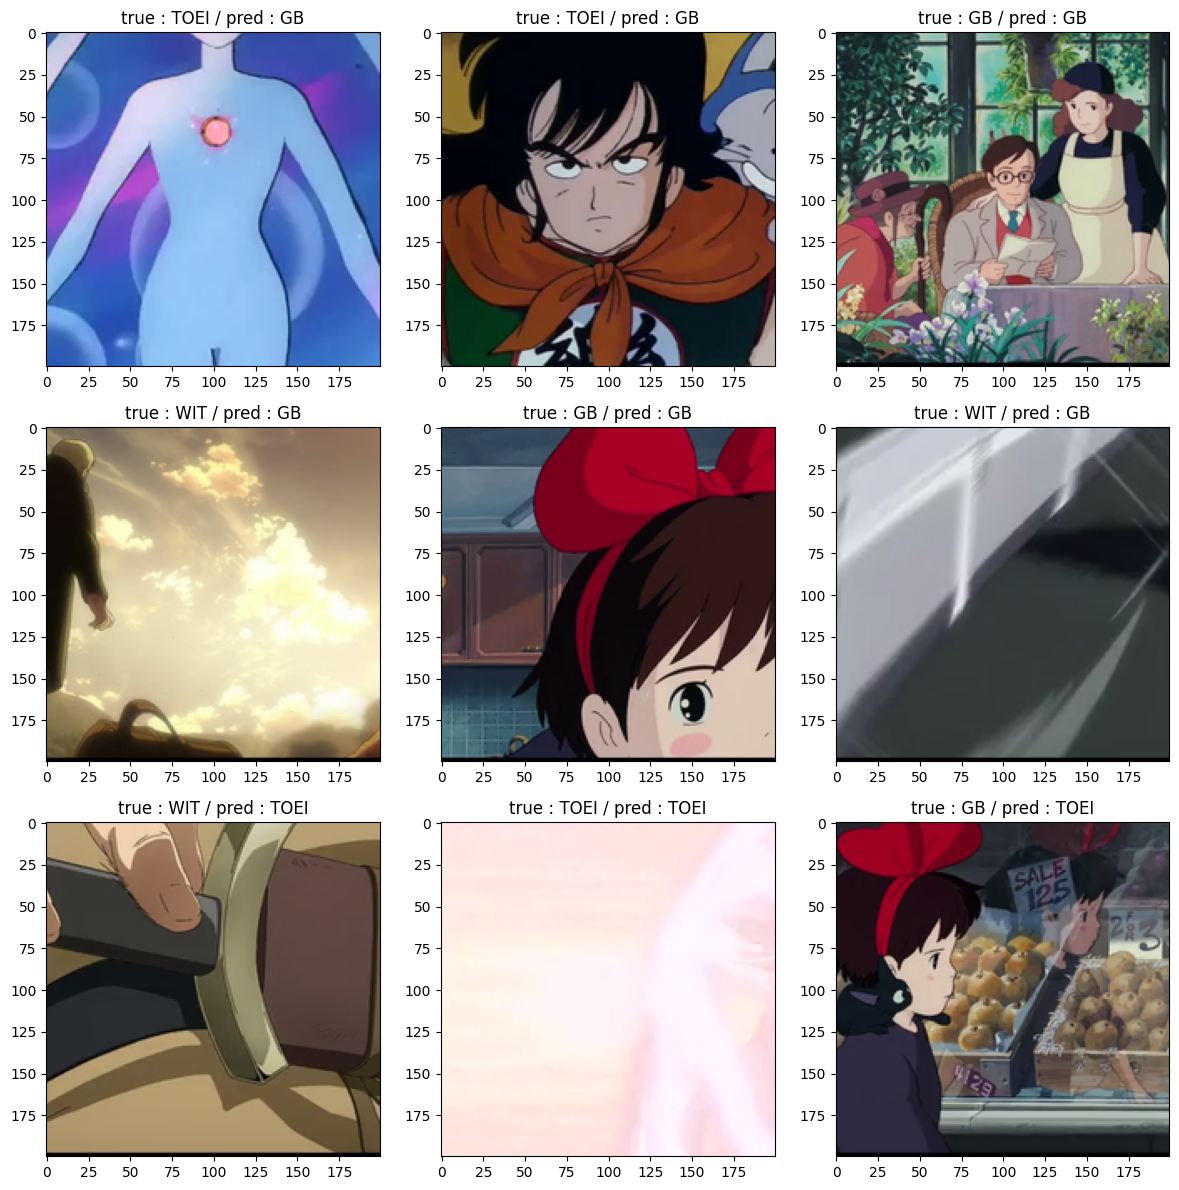

In [ ]:
indices = np.arange(len(test['x']))
np.random.shuffle(indices)

plt.figure(figsize=(12, 12))

for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    random_index = indices[i]  # Utiliser les indices aléatoires

    classe_attendue = str(CLASSES[int(test['y'][random_index])])
    classe_predite = str(CLASSES[np.argmax(predictions[random_index])])

    plt.title("true : " + classe_attendue + " / pred : " + classe_predite)
    plt.imshow(test['x'][random_index])

plt.tight_layout()
plt.show()

In [ ]:
exportModel(model, 'AlexNetExtended')

TRANSFER LEARNING
------------------------------
Conv
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2

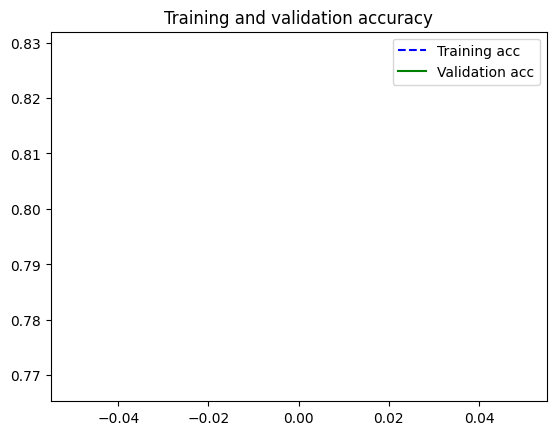

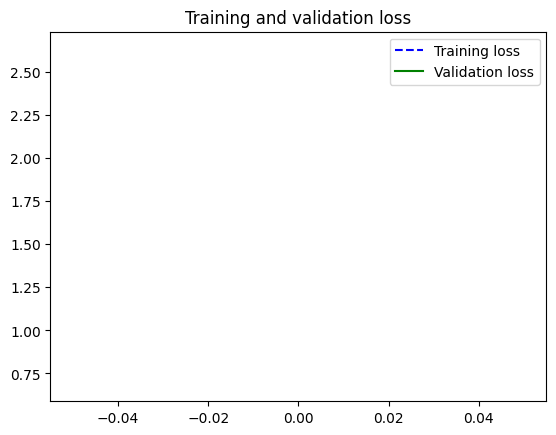

18/18 [==============================] - 0s 4ms/step
Accuracy: 0.8169014084507042
Precision: 0.8168789181823222
Recall: 0.8169014084507042
F1 Score: 0.8166419097491234


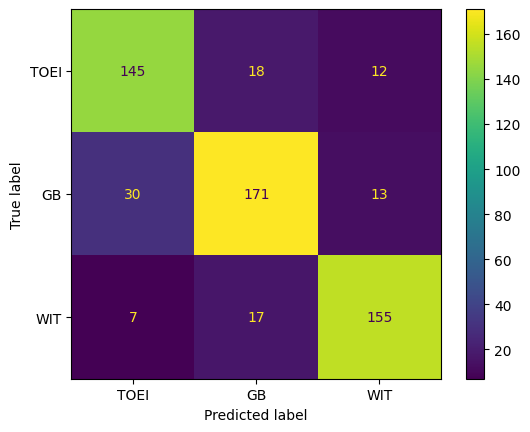

In [ ]:
transferLearningModel(model="VGG16", epochs=1, fine_tuning=False)

TRANSFER LEARNING
------------------------------
Conv
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2

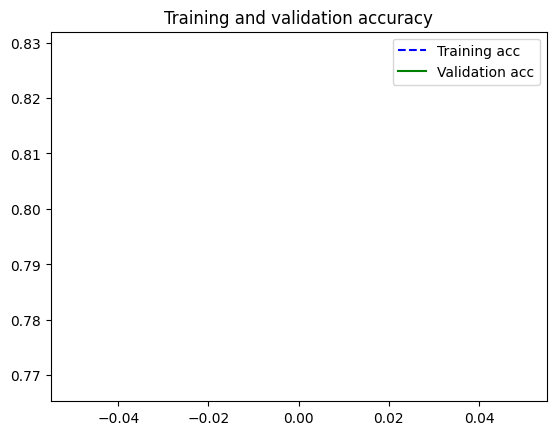

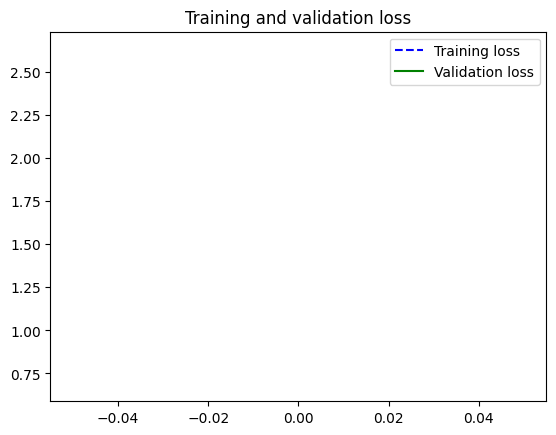

18/18 [==============================] - 0s 4ms/step
Accuracy: 0.8169014084507042
Precision: 0.8168789181823222
Recall: 0.8169014084507042
F1 Score: 0.8166419097491234


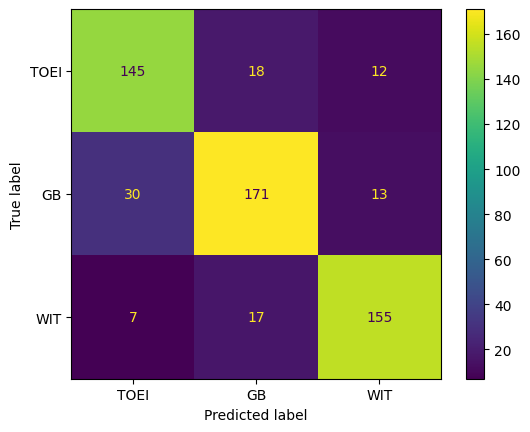

In [ ]:
transferLearningModel(model="VGG16", epochs=1, fine_tuning=True)

In [ ]:
transferLearningModel(model="VGG19", epochs=50)